## Proyecto en Grupo – Regresión Avanzada<br>*Predicción de Precios de Bienes Raíces en Australia*

---
**Integrantes:**
- Carlos Andrés Pérez Guzmán

## Índice


- [Índice](#índice)
- [Introducción](#introducción)
  - [Métodos Utilizados](#métodos-utilizados)
  - [Tecnologías](#tecnologías)
- [Descarga y Configuración](#descarga-y-configuración)
  - [Requisitos Previos](#requisitos-previos)
  - [Cómo Ejecutar](#cómo-ejecutar)
- [Declaración del Problema](#declaración-del-problema)
  - [Objetivo Comercial](#objetivo-comercial)
  - [Preparación de Datos:](#preparación-de-datos)
  - [Construcción y Evaluación del Modelo](#construcción-y-evaluación-del-modelo)
  - [Conclusiones](#conclusiones)
    - [Regresión Ridge](#regresión-ridge)
    - [Regresión Lasso](#regresión-lasso)
    - [Regresión ElasticNet](#regresión-lasso)
    - [Las Variables Más Significativas Son:](#las-variables-más-significativas-son)


### Introducción


...


#### Métodos Utilizados
...


#### Tecnologías
* Python
* Pandas
...


### Descarga y Configuración
#### Requisitos Previos

Este proyecto necesita que Anaconda esté instalado en la computadora.


Para más detalles sobre la instalación, visite: https://docs.anaconda.com/anaconda/install/index.html


#### Cómo Ejecutar


Puede descargar el código fuente clonando este repositorio usando Git:


1. Abra su aplicación Terminal favorita (Unix, Linux o Macos), como Terminal, Comando, Consola, iTerm2, etc.


2. Clone el repositorio


```
git clone <GITHUB_REPO_URL>
```


3. Abra el archivo notebook ** *.ipynb** en Anaconda.


```
jupyter notebook <FILE.ipynb
```




### Declaración del Problema


...


#### Objetivo Comercial


...


---



### **Preparación de Datos**


#### 1. Limpieza de Datos y Análisis de Datos Faltantes.

Librerías

In [123]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from catboost import Pool, CatBoostRegressor

Limpieza de información

In [103]:
import polars as pl

data = pl.read_csv(
    source='./Data/dataset.csv',
    infer_schema=False,
    null_values=['NA', '', ' ', '-', 'null']
)

mapping_char = {'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U', 'Ü': 'U'}

# Limpieza de texto
data = data\
    .with_columns(
        pl.all()
        .str.to_uppercase()
        .str.replace_all(r'\s+', ' ')
        .str.strip_chars()
        .str.replace_many(mapping_char)
    )\
    .select(pl.all().replace({' ': None}))

In [104]:
# Verificar calidad de información
data\
    .null_count()\
    .transpose( include_header = True )\
    .with_columns( (pl.col("column_0") / total_rows * 100).alias("null_percentage") )\
    .filter( pl.col('column_0') > 0 )\
    .sort('column_0', descending = True)

column,column_0,null_percentage
str,u32,f64
"""PoolQC""",1453,99.520548
"""MiscFeature""",1406,96.30137
"""Alley""",1369,93.767123
"""Fence""",1179,80.753425
"""FireplaceQu""",690,47.260274
…,…,…
"""BsmtCond""",37,2.534247
"""BsmtFinType1""",37,2.534247
"""MasVnrType""",8,0.547945


In [105]:
# Exportar archivo mejorado
#data.write_parquet( file = './Data/data.parquet', compression = 'lz4' )
data.write_csv(file = './Data/data.csv', separator = ';')

Carga de información

In [106]:
data = pd.read_csv ( filepath_or_buffer = './Data/data.csv', sep = ';' )
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [107]:
# Convertir variables categóricas en variables numéricas usando One-Hot Encoding
data_encoded = pd.get_dummies(data, drop_first=True)

# Definir variable objetivo y características
X = data_encoded.drop('SalePrice', axis=1, errors='ignore')
y = data_encoded['SalePrice']

# Imputar valores faltantes con la media de cada columna
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# 1. Selección basada en correlación
# Calcular la correlación con la variable objetivo y seleccionar características con alta correlación
correlation_matrix = data_encoded.corr()
correlation_with_target = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)

# Seleccionar características con una correlación mayor a 0.6 como umbral
correlated_features = correlation_with_target[correlation_with_target > 0.5].index.tolist()
correlated_features.remove('SalePrice')

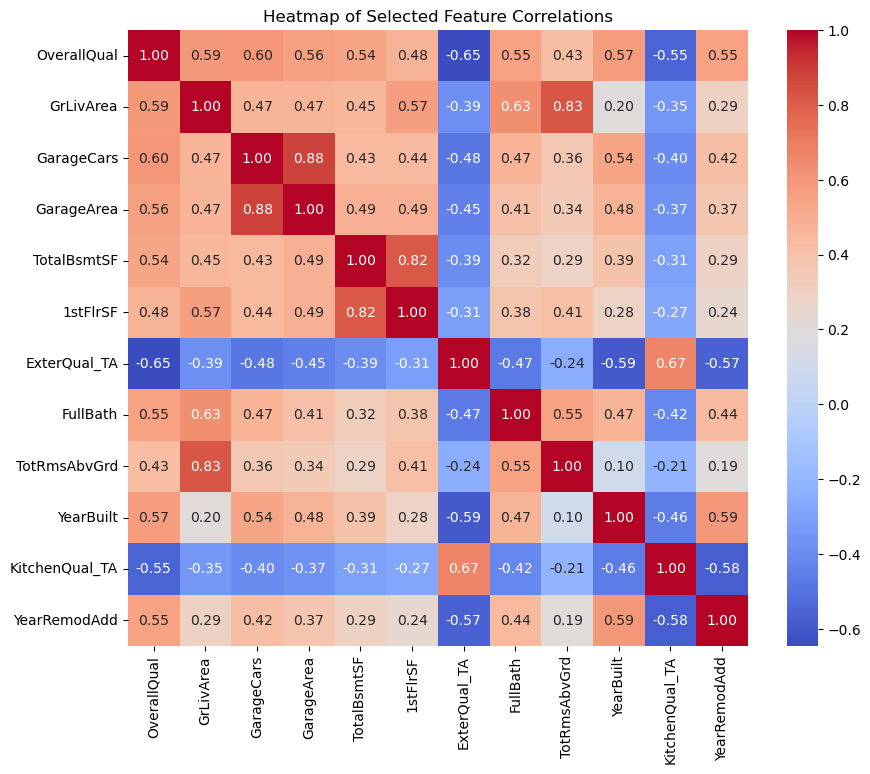

In [108]:

# Crear matriz de correlación para estas características
selected_corr_matrix = data_encoded[correlated_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(selected_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Selected Feature Correlations")
plt.show()

#### 2. Modelos de Regresión y Regularización

#### Linear Regression

Mean Squared Error (MSE): 1559299894.954661
R² Score: 0.7967100938297004
Prediction Accuracy: 79.67100938297004%


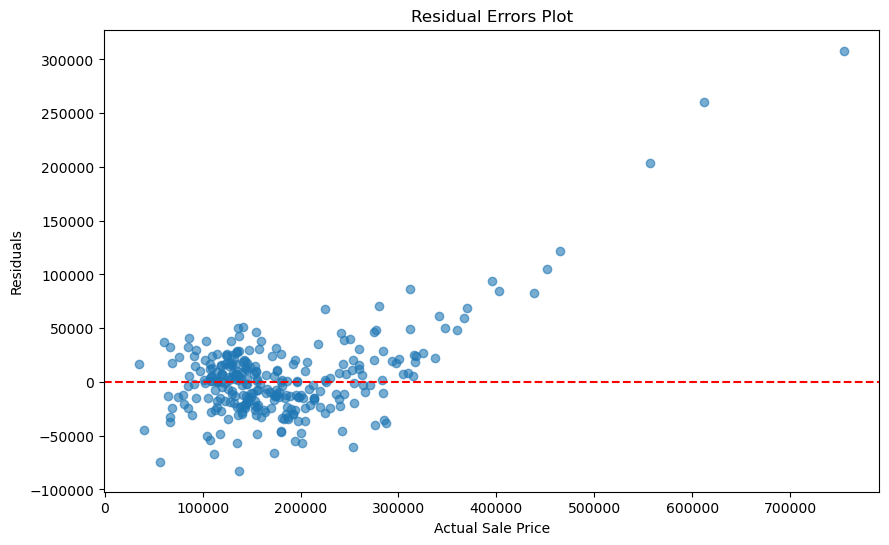

In [109]:
# 2. Dividir el conjunto de datos en entrenamiento y prueba
X_selected = data_encoded[correlated_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = model.score(X_test, y_test) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
print(f"Prediction Accuracy: {accuracy}%")

# Graficar los errores residuales
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Sale Price")
plt.ylabel("Residuals")
plt.title("Residual Errors Plot")
plt.show()

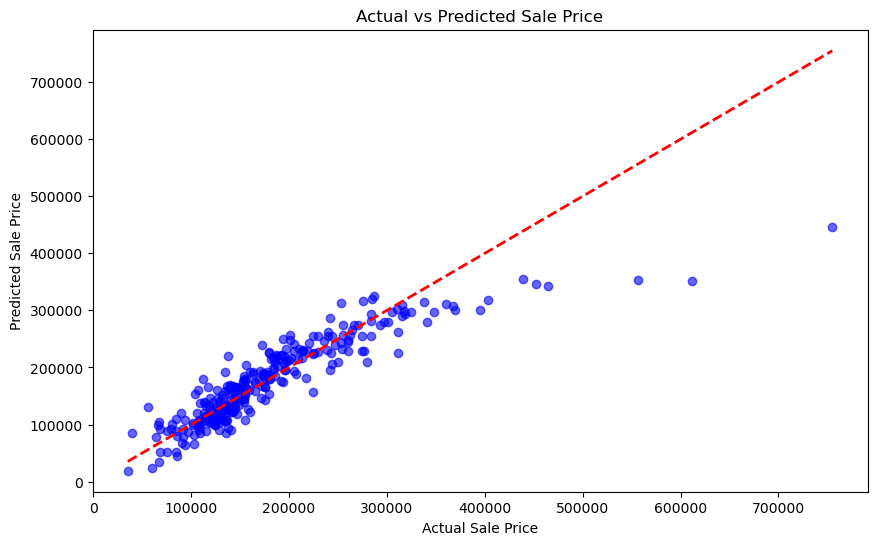

'SalePrice = -973525.95 + (18095.92) * OverallQual + (46.28) * GrLivArea + (11333.58) * GarageCars + (13.51) * GarageArea + (14.19) * TotalBsmtSF + (15.65) * 1stFlrSF + (-6795.96) * ExterQual_TA + (-8097.72) * FullBath + (996.59) * TotRmsAbvGrd + (256.20) * YearBuilt + (-7564.91) * KitchenQual_TA + (213.02) * YearRemodAdd '

In [110]:
# Obtener los coeficientes y el intercepto del modelo
coefficients = model.coef_
intercept = model.intercept_

# Crear una gráfica de dispersión de los valores reales frente a los valores predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", linewidth=2)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Price")

# Mostrar la gráfica
plt.show()

# Crear la ecuación del modelo como una cadena
equation = f"SalePrice = {intercept:.2f} "
for i, coef in enumerate(coefficients):
    equation += f"+ ({coef:.2f}) * {correlated_features[i]} "

equation

#### RIDGE

In [111]:
# Convertir variables categóricas en variables numéricas usando One-Hot Encoding
data_encoded = pd.get_dummies(data, drop_first=True)

# Definir variable objetivo y características
X = data_encoded.drop('SalePrice', axis=1, errors='ignore')
y = data_encoded['SalePrice']

# Imputar valores faltantes con la media de cada columna
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Selección basada en correlación (>0.5 con SalePrice)
correlation_matrix = data_encoded.corr()
correlation_with_target = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)
correlated_features = correlation_with_target[correlation_with_target > 0.5].index.tolist()
correlated_features.remove('SalePrice')

In [112]:
# Seleccionar características y dividir datos
X_selected = data_encoded[correlated_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Configurar el modelo Ridge con GridSearchCV para encontrar el mejor alpha
alpha_range = np.logspace(-3, 3, 50)
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid={'alpha': alpha_range}, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)

# Obtener el mejor alpha y el modelo
best_alpha = ridge_cv.best_params_['alpha']
ridge_best_model = ridge_cv.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred_ridge = ridge_best_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Mejor valor de alpha: {best_alpha}")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"R² Score: {r2_ridge}")


Mejor valor de alpha: 79.06043210907701
Mean Squared Error (MSE): 1554704606.5310607
R² Score: 0.7973091933072812


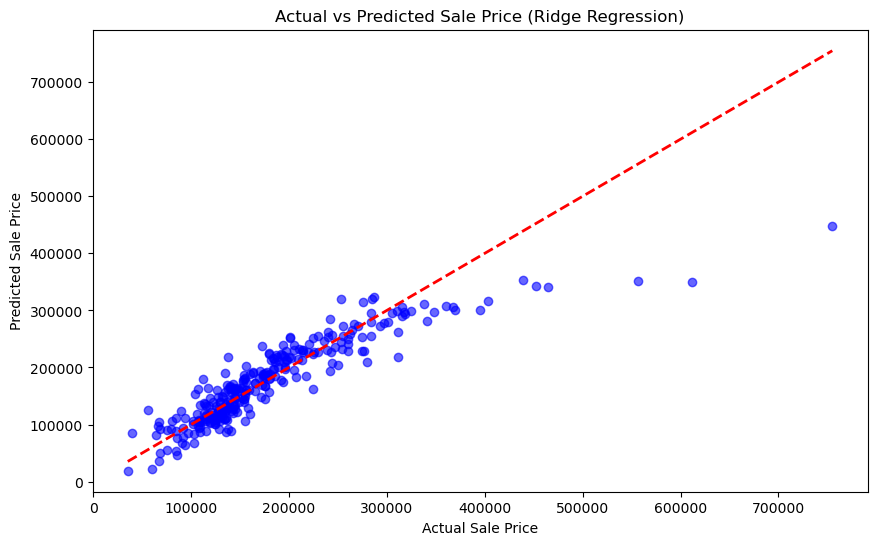

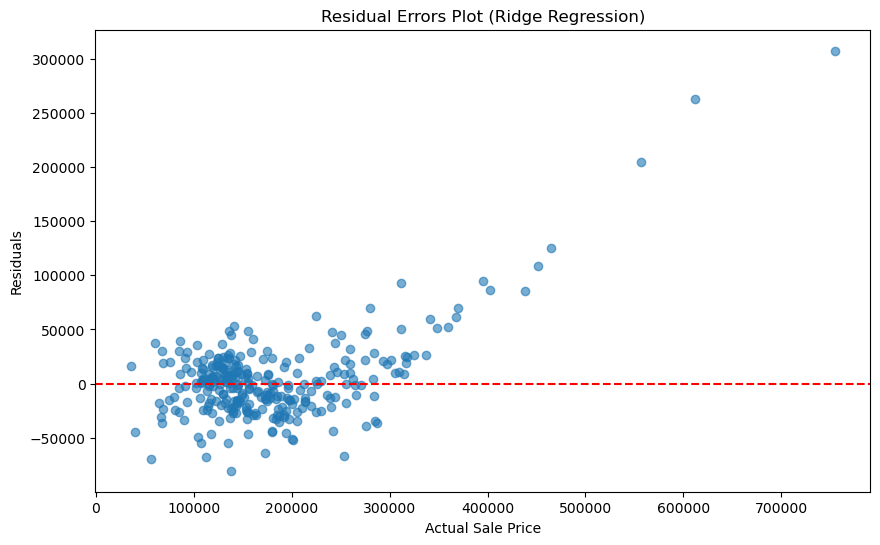

In [113]:

# Graficar Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", linewidth=2)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Price (Ridge Regression)")
plt.show()

# Graficar errores residuales
residuals = y_test - y_pred_ridge
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Sale Price")
plt.ylabel("Residuals")
plt.title("Residual Errors Plot (Ridge Regression)")
plt.show()

#### LASSO

Train R^2: 0.77
Test R^2: 0.80
Train MSE: 1384383288.90
Test MSE: 1559311179.68


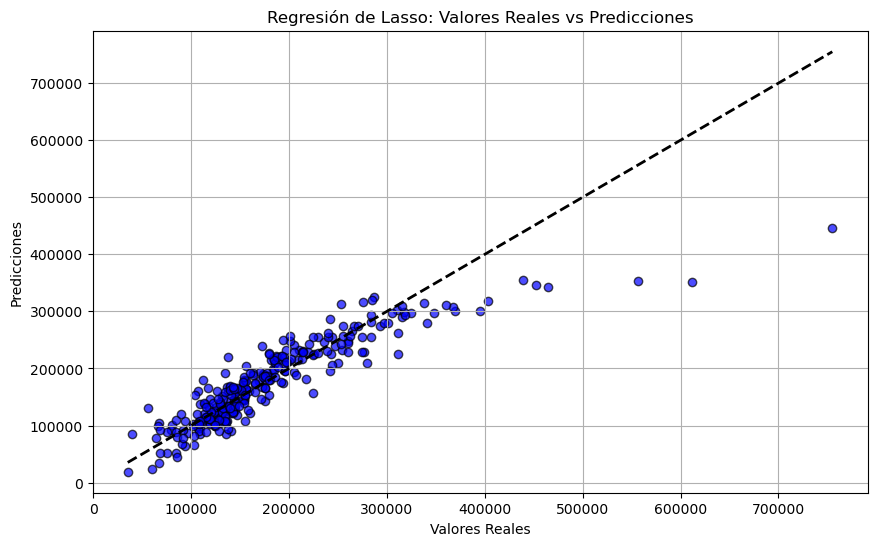

In [114]:
# Importar Librerias Requeridas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ignorar Alertas (Warnings)
import warnings
warnings.filterwarnings('ignore')

# Definir precision del FLOAT a dos digitos.
pd.options.display.float_format = '{:.2f}'.format

# Supongamos que ya tienes X_train, X_test, y_train, y_test definidos
# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo de regresión de Lasso
lasso = Lasso(alpha=1.0)  # Puedes ajustar el parámetro alpha según sea necesario
lasso.fit(X_train_scaled, y_train)

# Realizar predicciones
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

# Evaluar el modelo
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Train R^2: {train_r2:.2f}')
print(f'Test R^2: {test_r2:.2f}')
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Regresión de Lasso: Valores Reales vs Predicciones')
plt.grid(True)
plt.show()

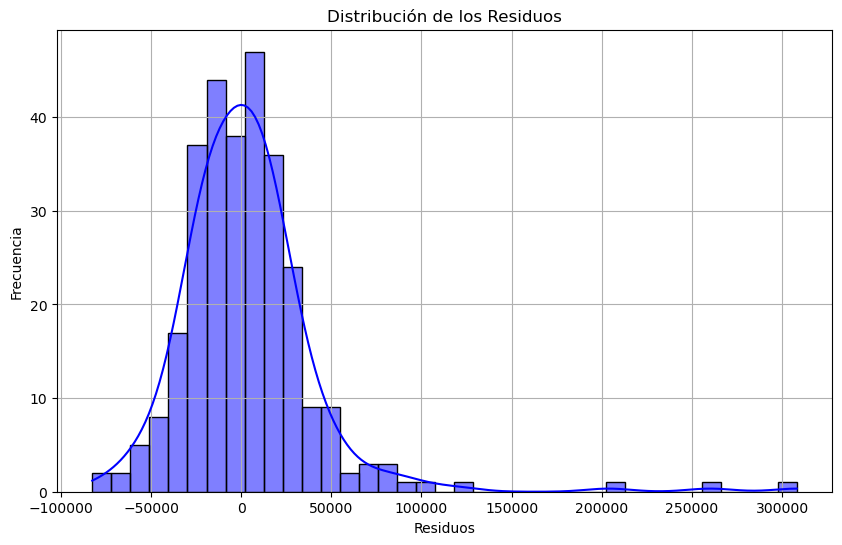

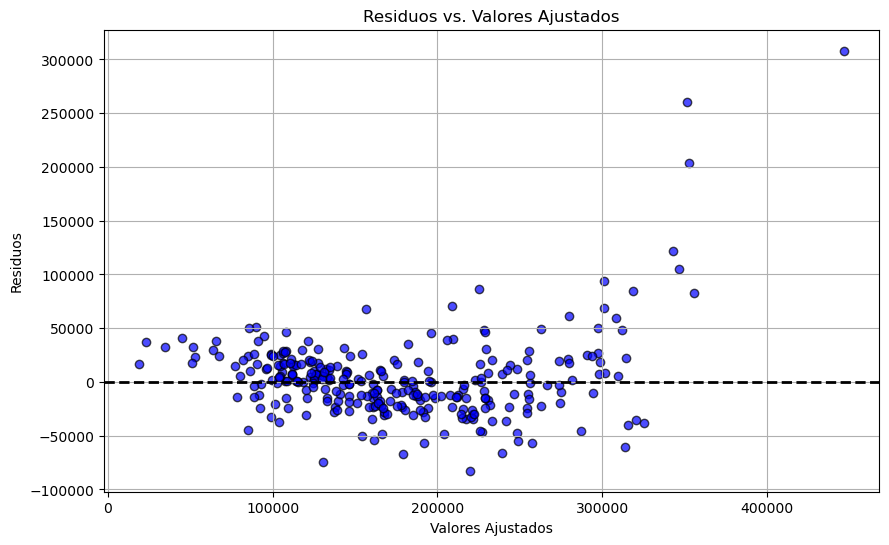

In [115]:
# Distribución de los Residuos
residuos = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True, color='blue')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de los Residuos')
plt.grid(True)
plt.show()

# Gráfica de Residuos vs. Valores Ajustados
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuos, color='blue', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs. Valores Ajustados')
plt.grid(True)
plt.show()



#### 3. Derivación de Columnas Categóricas.


In [116]:
# Identificar las columnas categóricas
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

print("Columnas categóricas:", categorical_columns)
print("Número de columnas categóricas:", len(categorical_columns))

# Convertir todas las columnas categóricas a cadenas
data[categorical_columns] = data[categorical_columns].astype(str)

# Aplicar One-Hot Encoding utilizando pandas.get_dummies
df_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
print("DataFrame después de One-Hot Encoding:")
print(df_encoded.head())

Columnas categóricas: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Número de columnas categóricas: 43
DataFrame después de One-Hot Encoding:
   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60        65.00     8450            7            5       2003   
1   2          20        80.00     9600            6            8       1976   
2   3          60        68.00    11250            7            5       2001   
3   

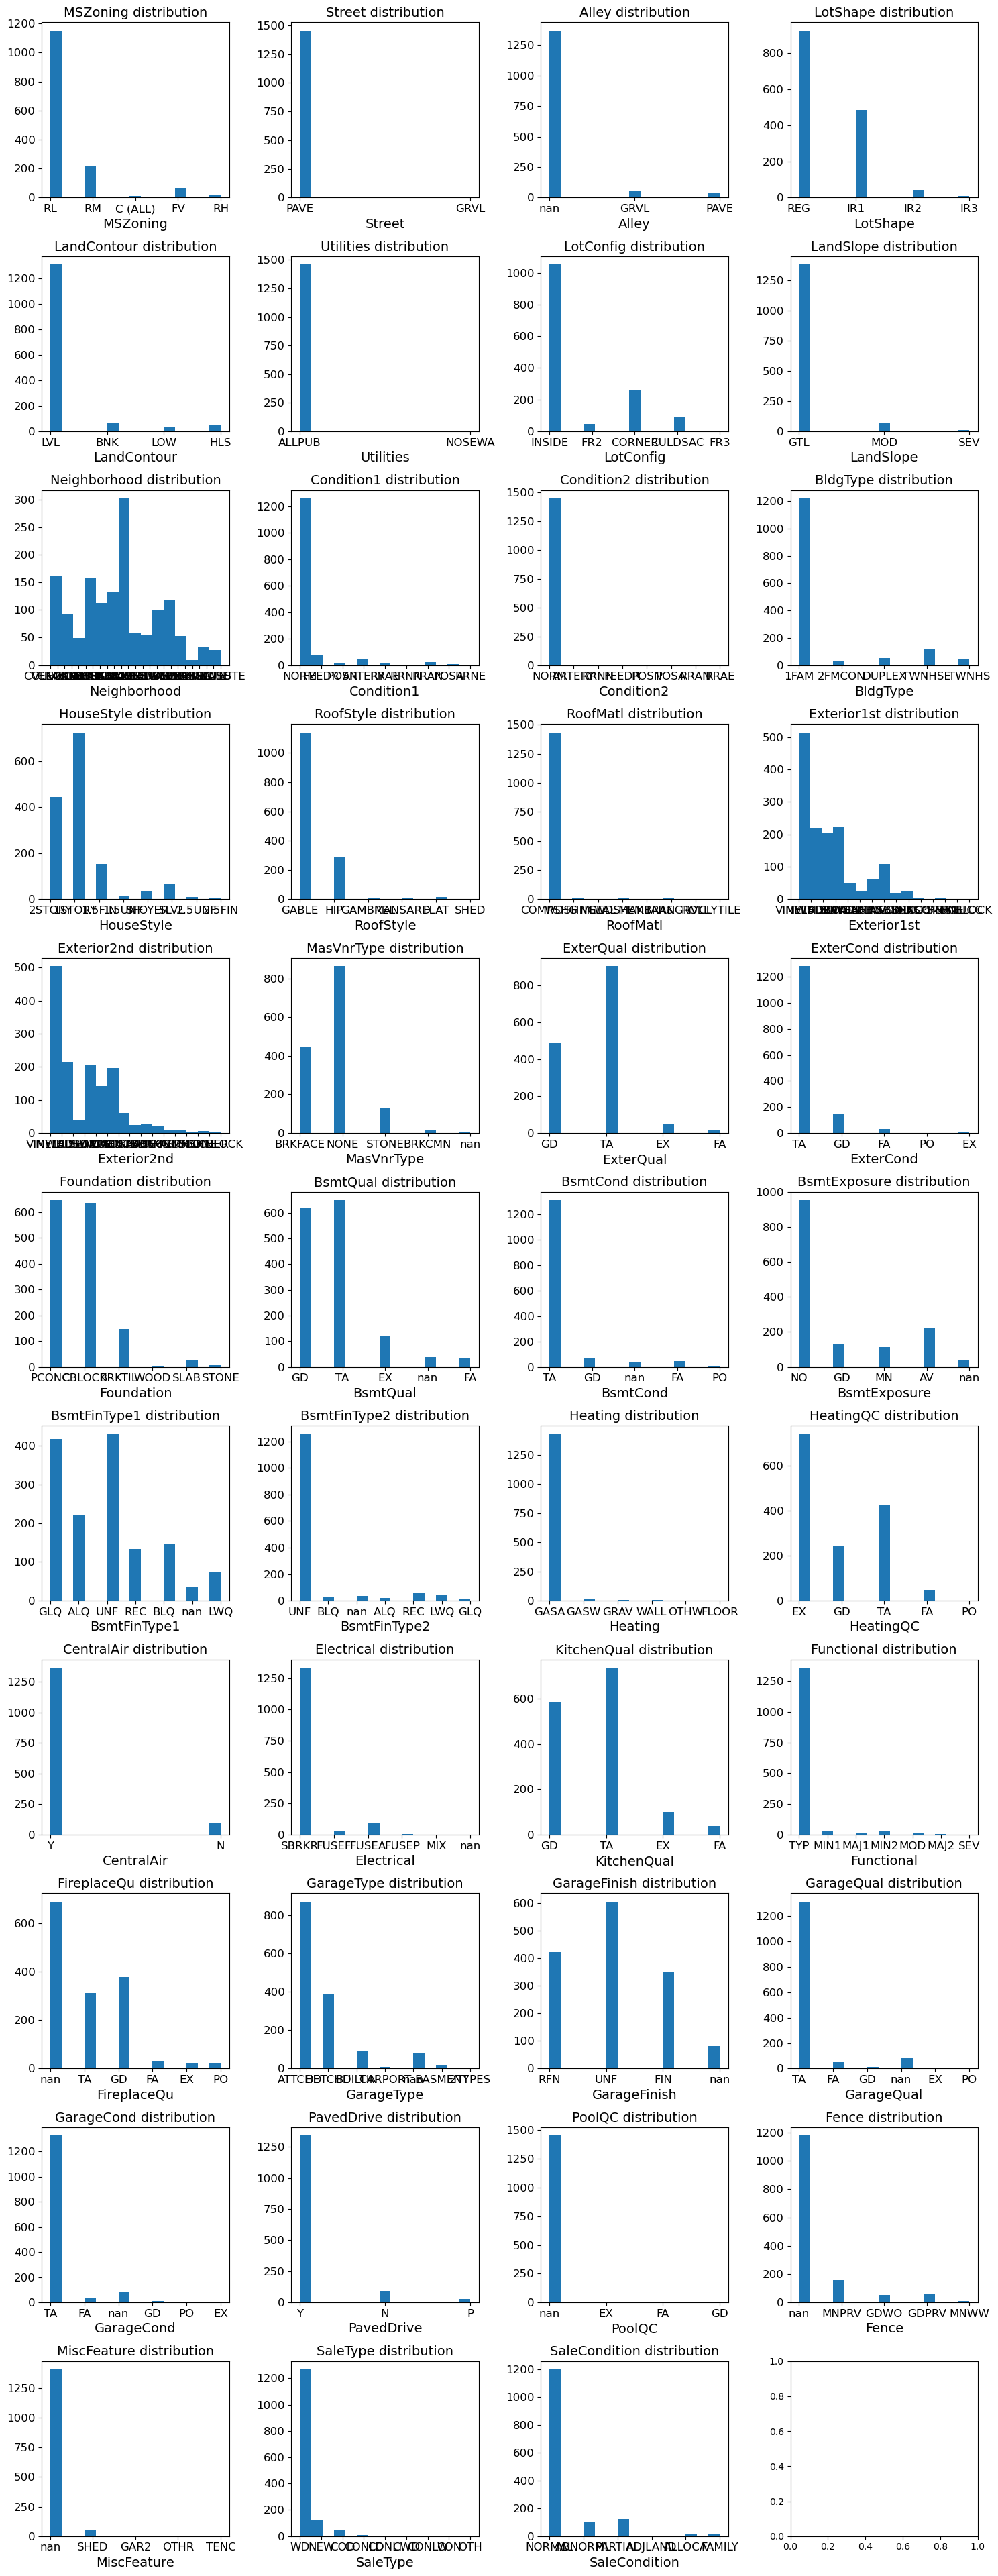

In [117]:
# Función para crear subplots de histogramas
def subplot_histograms(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(15, nrows*3.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        ax[i].hist(dataframe[column], bins=15)
        ax[i].set_title(f'{column} distribution', fontsize=14)
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
    plt.tight_layout()

# Llamar a la función para crear los histogramas
subplot_histograms(data, categorical_columns)

#### 4. Ingeniería y Selección de Características usando RFE


In [118]:
#df.head()

X=data.drop('SalePrice',axis=1)
y=data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [119]:
feature_names = list(X_train.columns)
cat_features = [column for column, dtype in X_train.dtypes.items() if dtype==object]

X_train[cat_features] = X_train[cat_features].fillna('NA')
X_test[cat_features] = X_test[cat_features].fillna('NA')

dataset_train_pool = Pool(X_train, y_train, feature_names=feature_names, cat_features=cat_features)
dataset_test_pool = Pool(X_test, y_test, feature_names=feature_names, cat_features=cat_features)

In [70]:
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm

def select_features_dataset(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostRegressor(iterations=500, random_seed=0)
    summary = model.select_features(
        dataset_train_pool,
        eval_set=dataset_test_pool,
        features_for_select=list(range(dataset_train_pool.num_col())),
        num_features_to_select=5,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

In [73]:
dataset_shap_summary = select_features_dataset(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['OverallQual', 'BsmtQual', 'GrLivArea', 'KitchenQual', 'GarageCars']


In [74]:
_ = select_features_dataset(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=9)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['Neighborhood', 'OverallQual', 'BsmtQual', '1stFlrSF', 'GrLivArea']


#### 4. Análisis Univariable.


#### 5. Análisis Bivariable.


##### Análisis Bivariable de Variables Numéricas

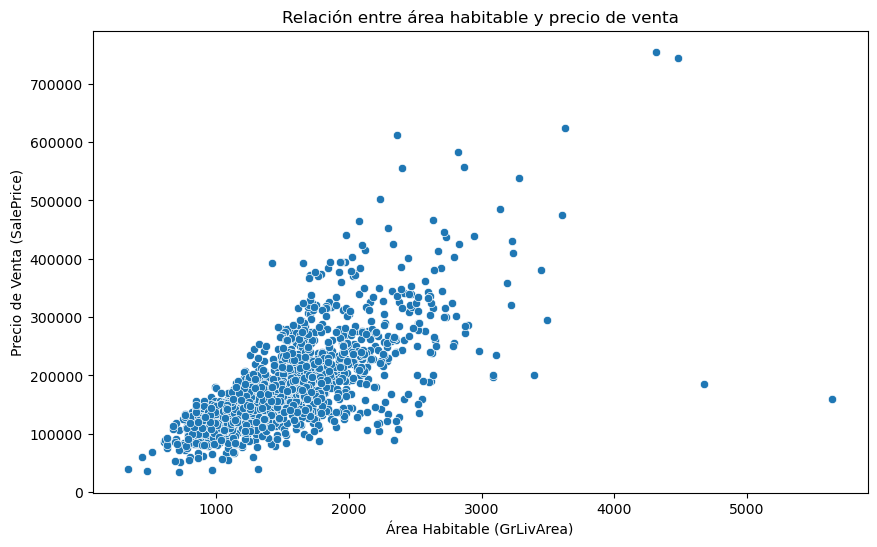

Correlación entre GrLivArea y SalePrice: 0.71


In [120]:
# Ejemplo de análisis bivariable entre 'GrLivArea' (área habitable) y 'SalePrice' (precio de venta)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=data)
plt.title('Relación entre área habitable y precio de venta')
plt.xlabel('Área Habitable (GrLivArea)')
plt.ylabel('Precio de Venta (SalePrice)')
plt.show()

# Cálculo de correlación entre 'GrLivArea' y 'SalePrice'
correlation = data['GrLivArea'].corr(data['SalePrice'])
print(f"Correlación entre GrLivArea y SalePrice: {correlation:.2f}")

##### Análisis Bivariable de Variables Categóricas

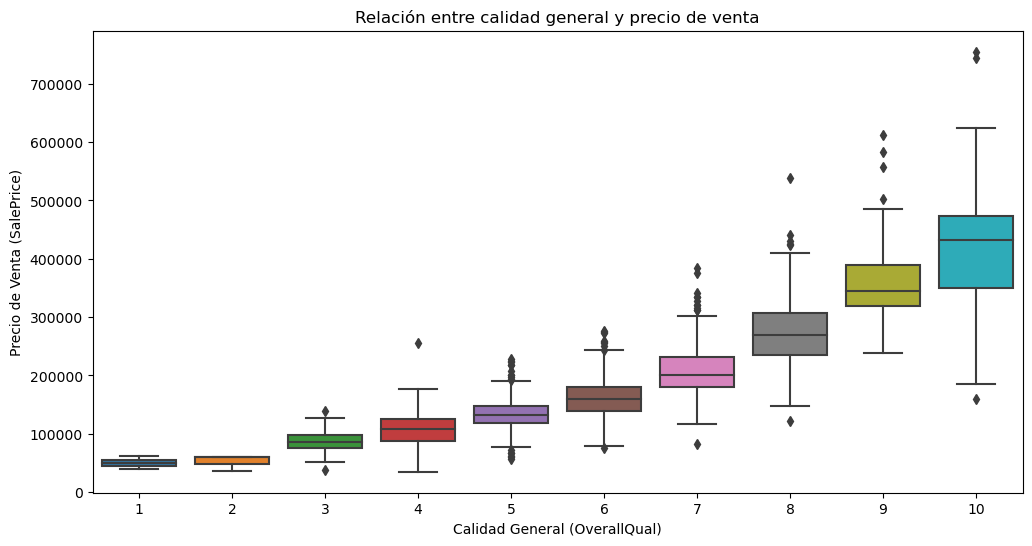

In [121]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=data)
plt.title('Relación entre calidad general y precio de venta')
plt.xlabel('Calidad General (OverallQual)')
plt.ylabel('Precio de Venta (SalePrice)')
plt.show()


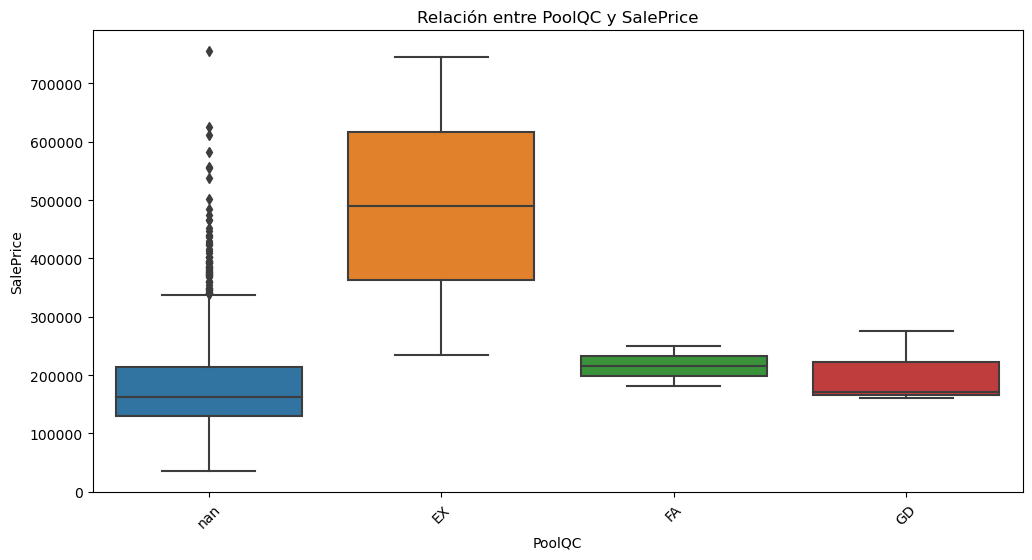

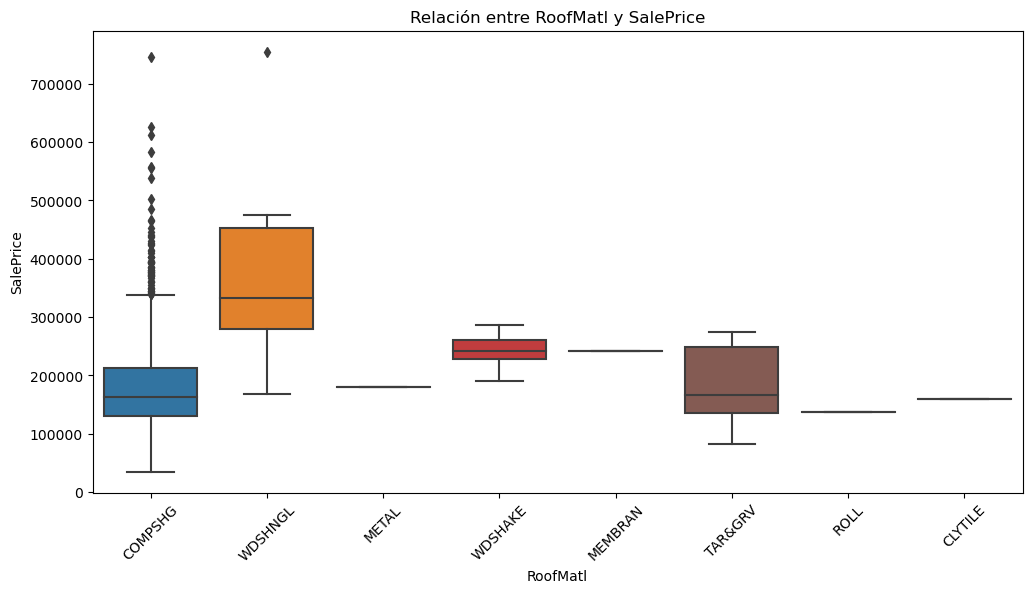

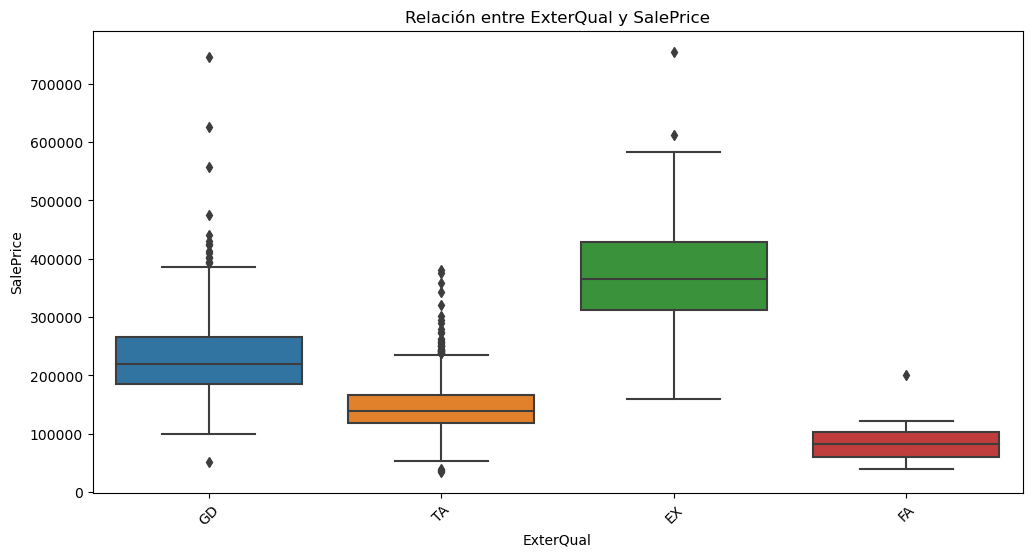

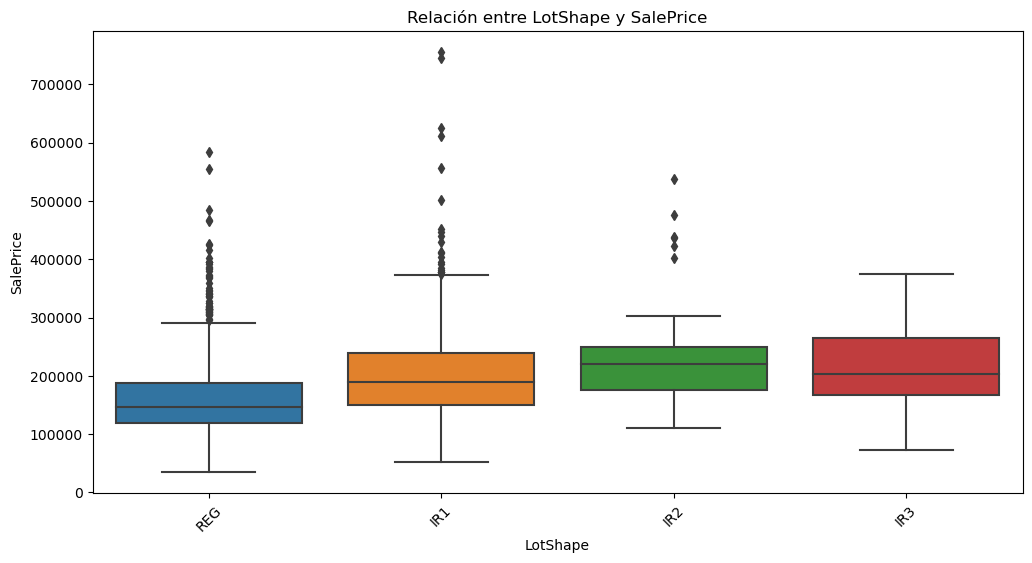

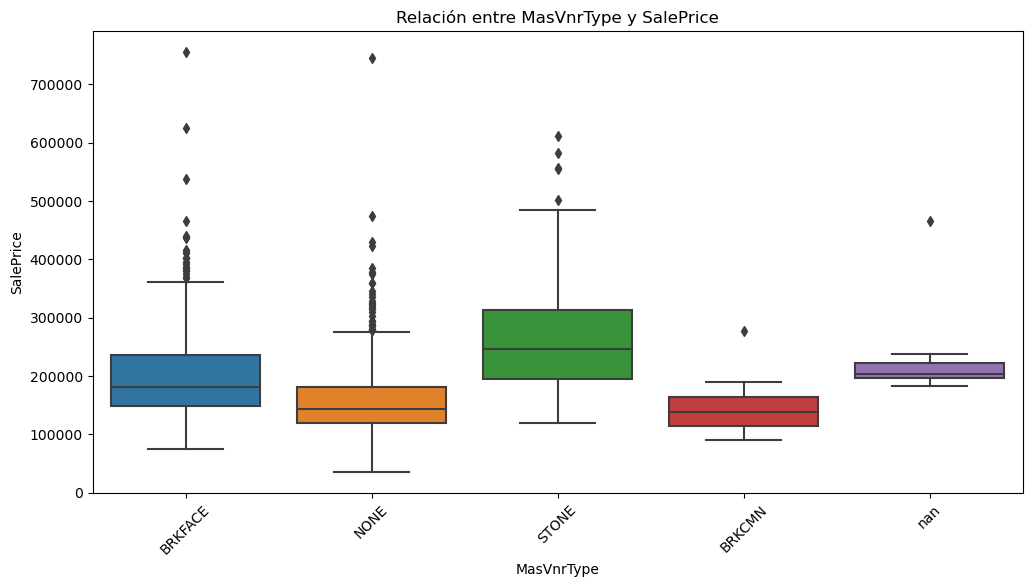

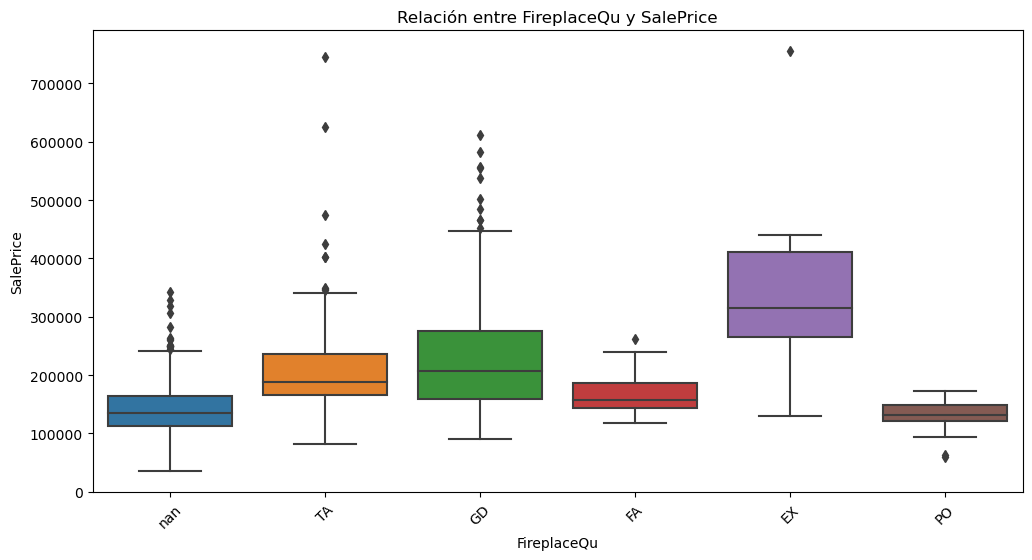

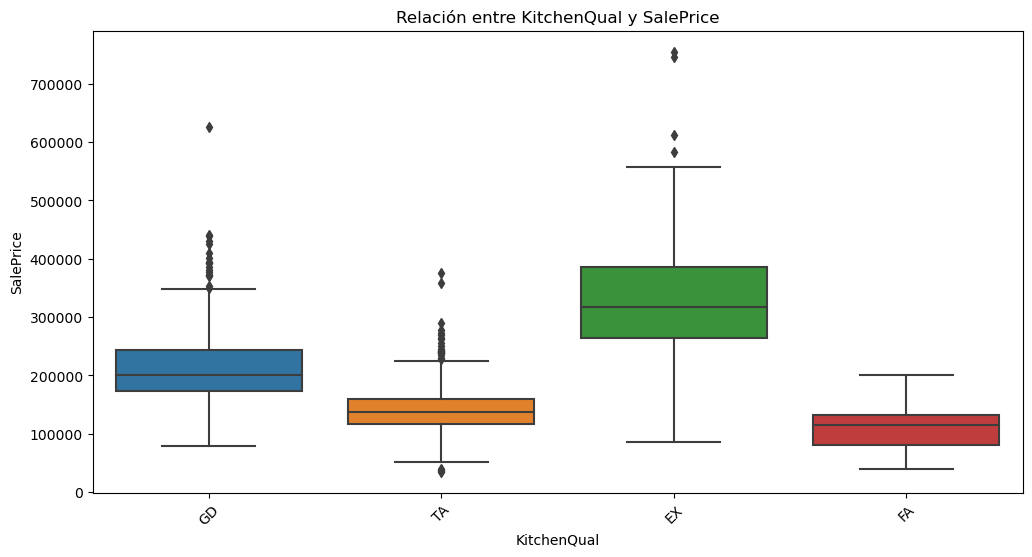

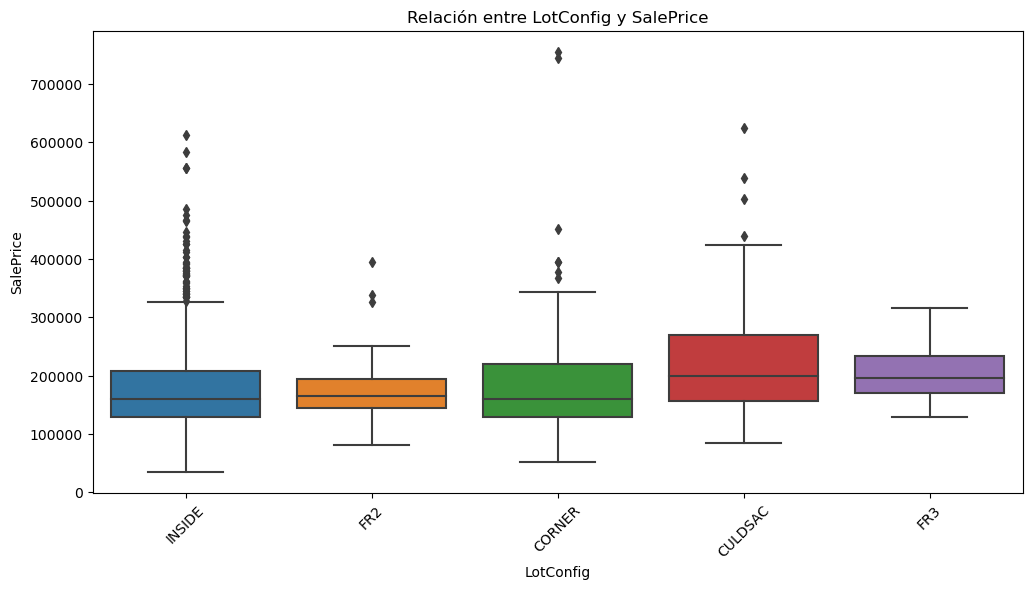

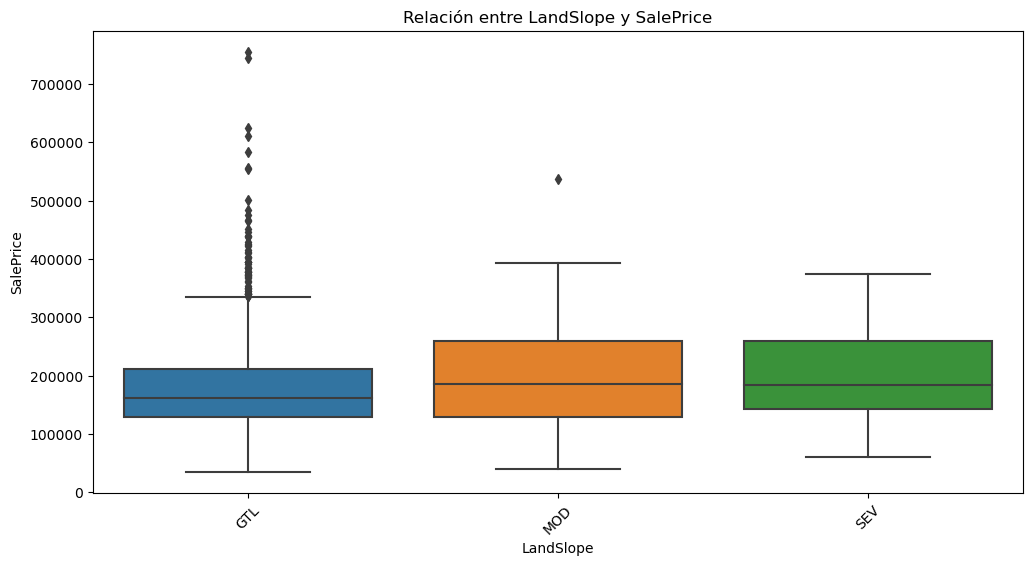

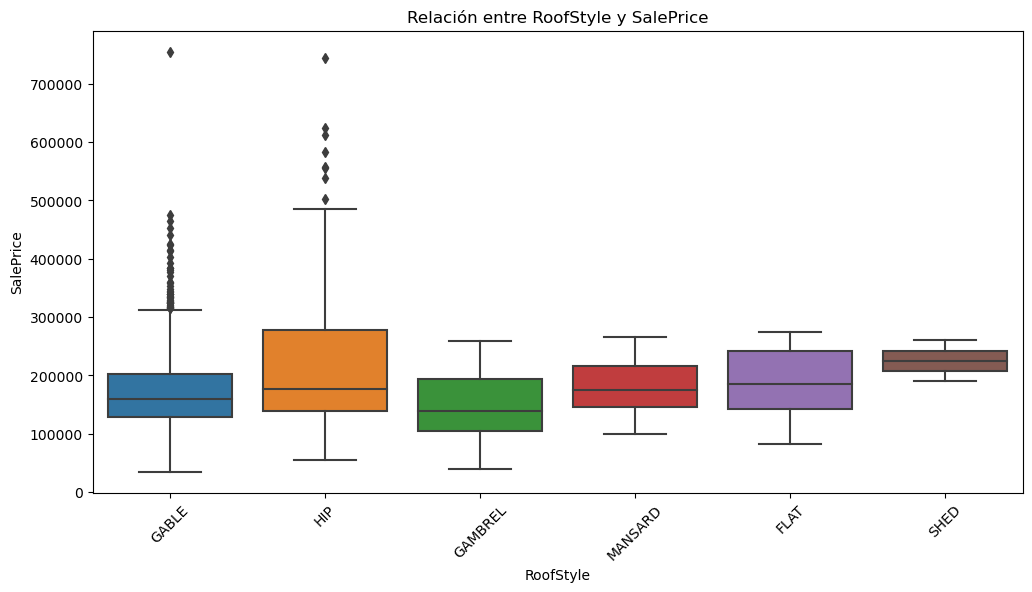

In [126]:
def top_categorical_analysis(df, target_var, top_n=10):
    categorical_vars = df.select_dtypes(include=['object']).columns
    avg_target_by_cat = {}

    # Calcular la media de la variable objetivo para cada variable categórica
    for var in categorical_vars:
        if df[var].nunique() < 20:  # Limitar el análisis a variables con pocas categorías
            mean_target = df.groupby(var)[target_var].mean().mean()
            avg_target_by_cat[var] = mean_target

    # Seleccionar las 10 variables categóricas con mayor impacto promedio en la variable objetivo
    top_cats = sorted(avg_target_by_cat, key=avg_target_by_cat.get, reverse=True)[:top_n]

    for var in top_cats:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=var, y=target_var, data=df)
        plt.title(f'Relación entre {var} y {target_var}')
        plt.xlabel(var)
        plt.ylabel(target_var)
        plt.xticks(rotation=45)
        plt.show()

# Llamada a la función
top_categorical_analysis(data, 'SalePrice')


#### 6. Análisis Multivariable.


In [124]:
# Seleccionar solo las columnas numéricas para el PCA, excluyendo 'Id' y 'SalePrice'
numerical_data = data.select_dtypes(include=['float64', 'int64']).drop(columns=['Id', 'SalePrice'], errors='ignore')

# Imputar los valores faltantes con la media de cada columna
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(numerical_data)

# Estandarizar los datos numéricos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Aplicar PCA y reducir a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear un DataFrame con los componentes principales
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

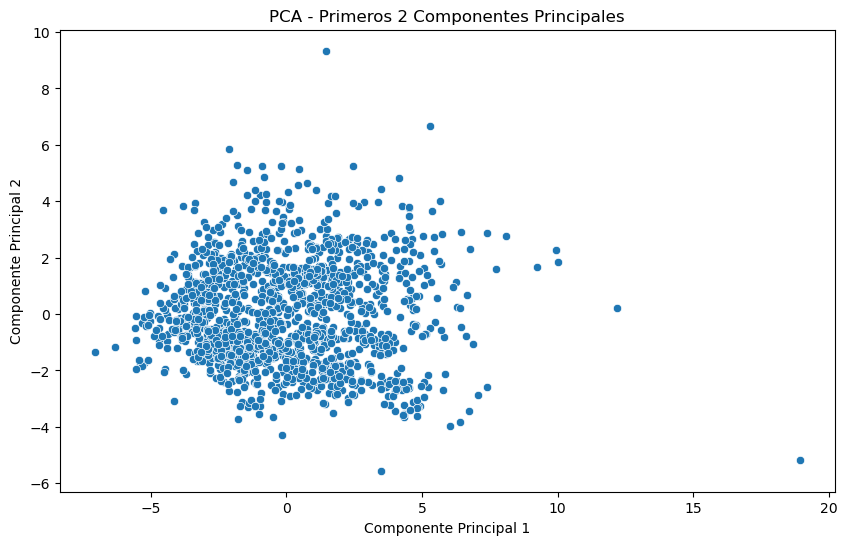

Varianza explicada por el Componente Principal 1: 19.81%
Varianza explicada por el Componente Principal 2: 8.90%
     MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
PC1   -0.016288     0.161077  0.106870     0.301749    -0.083399   0.237723   
PC2    0.165105    -0.011874 -0.030783    -0.018528     0.060616  -0.197508   

     YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  GarageArea  \
PC1      0.208700    0.195979    0.140428   -0.012373  ...    0.279006   
PC2     -0.087321   -0.020522   -0.290321   -0.070096  ...   -0.101574   

     WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
PC1    0.133558     0.149336      -0.074684   0.016652      0.03069  0.050009   
PC2   -0.068025     0.039478       0.117990  -0.030258      0.01694  0.014055   

      MiscVal    MoSold    YrSold  
PC1 -0.010975  0.021903 -0.013367  
PC2  0.026760  0.028599 -0.036240  

[2 rows x 36 columns]


In [21]:

# Graficar los datos en el espacio de los primeros dos componentes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title("PCA - Primeros 2 Componentes Principales")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

# Mostrar la varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por el Componente Principal 1: {explained_variance[0]:.2%}")
print(f"Varianza explicada por el Componente Principal 2: {explained_variance[1]:.2%}")
pca_components = pd.DataFrame(pca.components_, columns=numerical_data.columns, index=['PC1', 'PC2'])
print(pca_components)

In [125]:
# DataFrame con las cargas de cada variable en los componentes principales
pca_components = pd.DataFrame(pca.components_, columns=numerical_data.columns, index=['PC1', 'PC2'])

# Ordenar las cargas de PC1 en orden descendente para facilitar la interpretación
pca_components_sorted = pca_components.loc['PC1'].abs().sort_values(ascending=False).to_frame(name='Carga_PC1')
pca_components_sorted['Carga_PC2'] = pca_components.loc['PC2'][pca_components_sorted.index]

pca_components_sorted


,Carga_PC1,Carga_PC2
OverallQual,0.30,-0.02
GrLivArea,0.30,0.25
GarageCars,0.28,-0.07
GarageArea,0.28,-0.10
FullBath,0.26,0.15
TotalBsmtSF,0.26,-0.21
1stFlrSF,0.26,-0.15
TotRmsAbvGrd,0.24,0.33
YearBuilt,0.24,-0.20
GarageYrBlt,0.22,-0.14


### Construcción y Evaluación del Modelo


1. División de datos de entrenamiento y prueba.
2. Escalado de Características - StandardScaler.
3. Ingeniería y Selección de Características usando RFE y el Factor de Inflación de Varianza.
4. Preparación del modelo usando OLS & Regresión Lineal.
5. Modelos de Regularización Ridge, Lasso y ElasticNet.
6. Análisis de Residuos.
7. Evaluación y Valoración del Modelo.
8. Predicción.
9. Conclusión y Análisis Final.


### Conclusiones


### Conclusions


R2_Score for Ridge regresion.... 
R2_Score for Lasso regresion.... 
R2_Score for ElasticNet regresion.... 


#### Ridge Regression
* **Optimal Lambda Value:** ##
* **R2 Score Train:** 0.##
* **R2 Test Score:**  0.##
* **RMSE Test:**      0.##


#### Lasso Regression
* **Optimal Lambda Value:** 0.####
* **R2 Score Train:**  0.##
* **R2 Test Score:**   0.##
* **RMSE Test:**       0.##


#### ElasticNet Regression
* **Optimal Lambda Value:** 0.####
* **R2 Score Train:**  0.##
* **R2 Test Score:**   0.##
* **RMSE Test:**       0.##


#### Las Variables Más Significativas Son:
* ...
* ...
* ...
* ...
